<a href="https://colab.research.google.com/github/bluetinue/sharehouse/blob/main/CountryName.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 人名分类器


In [2]:
#@title 导包
# prompt: 装载谷歌硬盘
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
# 显示所有变量
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 导入torch工具
import torch
# 导入nn准备构建模型
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# 导入torch的数据源 数据迭代器工具包
from  torch.utils.data import Dataset, DataLoader
# 用于获得常见字母及字符规范化
import string
# 导入时间工具包
import time
# 引入制图工具包
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# @title 读取数据
data = pd.read_csv('/content/drive/MyDrive/NLP/data/name_classfication.txt',sep='\t')

In [4]:
# @title 数据预处理

#去重后的词表
all_letters = string.ascii_letters + " ,.:'"
n_letters = len(all_letters)
# 国家名 种类数
categorys = ['Italian', 'English', 'Arabic', 'Spanish', 'Scottish', 'Irish', 'Chinese', 'Vietnamese', 'Japanese',
             'French', 'Greek', 'Dutch', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Czech', 'German']
# 国家名 个数
categorynum = len(categorys)
print('categorys--->', categorys)
print('all_letters--->', all_letters)

# 读取数据
def read_data(path):
  x,y = [],[]
  with open(path,'r') as f:
    lines = f.readlines()
    for line in lines:
      line = line.strip().split('\t')
      x.append(line[0])
      y.append(line[1])
  return x,y

categorys---> ['Italian', 'English', 'Arabic', 'Spanish', 'Scottish', 'Irish', 'Chinese', 'Vietnamese', 'Japanese', 'French', 'Greek', 'Dutch', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Czech', 'German']
all_letters---> abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ ,.:'


In [28]:
#@title 数据加载器
#定义数据封装器类
class NameclassifcationDataset(Dataset):
    def __init__(self,x,y):
      #将读取的数据封装起来
        self.x = x
        self.y = y
        self.sample_len = len(x)

    #调用len方法返回x的数量
    def __len__(self):
        return self.sample_len

    #对进行切片操作时调用
    def __getitem__(self, idx):
      idx = min(max(0,idx),self.sample_len-1)

      x = self.x[idx]
      y = self.y[idx]

      tensor_x = torch.zeros(len(x),n_letters)
      for i,v in enumerate(x):
        tensor_x[i][all_letters.find(v)] = 1

      tensor_y = torch.tensor(categorys.index(y))

      return tensor_x,tensor_y

In [29]:
#@title 迭代器
def get_traindata():
  path = "/content/drive/MyDrive/NLP/data/name_classfication.txt"
  x,y = read_data(path)
  nameclassdataset = NameclassifcationDataset(x,y)
  train_loader = DataLoader(nameclassdataset,batch_size=1,shuffle=True)
  for x,y in train_loader:
    print(x.shape,y.shape)
    break
  return train_loader

In [32]:
#@title 构建RNN
# RNN类 实现思路分析：
# 1 init函数 准备三个层 self.rnn self.linear self.softmax=nn.LogSoftmax(dim=-1)
#    def __init__(self, input_size, hidden_size, output_size, num_layers=1)

# 2 forward(input, hidden)函数
#   让数据经过三个层 返回softmax结果和hn
#   形状变化 [seqlen,1,57],[1,1,128]) -> [seqlen,1,128],[1,1,128]

# 3 初始化隐藏层输入数据 inithidden()
#   形状[self.num_layers, 1, self.hidden_size]
class myRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1):
    super(myRNN, self).__init__()
    self.input_size = input_size
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.rnn = nn.RNN(input_size, hidden_size, num_layers)
    self.out = nn.Linear(hidden_size, output_size)
    # #根据后边的损失函数如果是CrossEntropyLoss,就不需要softmax，是NLLLoss就需要加上softmax
    # self.softmax = nn.LogSoftmax(dim=-1)

  #前向传播
  def forward(self,input,hidden):
    #input
    input = input.unsqueeze(1)

    rr,hn = self.rnn(input,hidden)
    tmprr = rr[-1]
    tmprr = self.out(tmprr)
    return tmprr,hn

  #初始化隐藏层输入数据
  def inithidden(self):
    return torch.zeros(self.num_layers, 1, self.hidden_size)


In [24]:
#@title 构建LSTM
# LSTM类 实现思路分析：
# 1 init函数 准备三个层 self.rnn self.linear self.softmax=nn.LogSoftmax(dim=-1)
#    def __init__(self, input_size, hidden_size, output_size, num_layers=1)

# 2 forward(input, hidden)函数
#   让数据经过三个层 返回softmax结果和hn
#   形状变化 [seqlen,1,57],[1,1,128]) -> [seqlen,1,128],[1,1,128]

# 3 初始化隐藏层输入数据 inithidden()
#   形状[self.num_layers, 1, self.hidden_size]
class myLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1):
    super().__init__()
    self.input_size = input_size
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
    self.out = nn.Linear(hidden_size, output_size)
    #根据后边的损失函数如果是CrossEntropyLoss,就不需要softmax，是NLLLoss就需要加上softmax
    self.softmax = nn.LogSoftmax(dim=-1)

  #前向传播
  def forward(self,input,hidden,c):
    #input
    input = input.unsqueeze(1)

    rr,(hn,cn) = self.lstm(input,(hidden,c))
    tmprr = rr[-1]
    tmprr = self.out(tmprr)
    return self.softmax(tmprr),hn,cn

  #初始化隐藏层输入数据
  def inithidden(self):
    hidden = c = torch.zeros(self.num_layers, 1, self.hidden_size)
    return hidden,c


In [25]:
#@title 构建GRU
# GRU类 实现思路分析：
# 1 init函数 准备三个层 self.rnn self.linear self.softmax=nn.LogSoftmax(dim=-1)
#    def __init__(self, input_size, hidden_size, output_size, num_layers=1)

# 2 forward(input, hidden)函数
#   让数据经过三个层 返回softmax结果和hn
#   形状变化 [seqlen,1,57],[1,1,128]) -> [seqlen,1,128],[1,1,128]

# 3 初始化隐藏层输入数据 inithidden()
#   形状[self.num_layers, 1, self.hidden_size]
class myGRU(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1):
    super().__init__()
    self.input_size = input_size
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.rnn = nn.GRU(input_size, hidden_size, num_layers)
    self.out = nn.Linear(hidden_size, output_size)
    #根据后边的损失函数如果是CrossEntropyLoss,就不需要softmax，是NLLLoss就需要加上softmax
    self.softmax = nn.LogSoftmax(dim=-1)

  #前向传播
  def forward(self,input,hidden):
    #input
    input = input.unsqueeze(1)

    rr,hn = self.rnn(input,hidden)
    tmprr = rr[-1]
    tmprr = self.out(tmprr)
    return self.softmax(tmprr),hn

  #初始化隐藏层输入数据
  def inithidden(self):
    return torch.zeros(self.num_layers, 1, self.hidden_size)


In [ ]:
#@title 思路分析
# 从文件获取数据、实例化数据源对象nameclassdataset 数据迭代器对象mydataloader
# 实例化模型对象my_rnn 损失函数对象mycrossentropyloss=nn.NLLLoss() 优化器对象myadam
# 定义模型训练的参数
#       starttime total_iter_num total_loss  total_loss_list total_acc_num  total_acc_list
# 外层for循环 控制轮数 for epoch_idx in range(epochs)
# 内层for循环 控制迭代次数 for i, (x, y) in enumerate(mydataloader)
    # 给模型喂数据   # 计算损失  # 梯度清零 # 反向传播  # 梯度更新
    # 计算辅助信息   # 累加总损失和准确数 每100次训练计算一个总体平均损失 总体平均准确率 每2000次训练 打印日志
    # 其他          # 预测对错 i_predit_tag = (1 if torch.argmax(output).item() == y.item() else 0)

# 模型保存
    # torch.save(my_rnn.state_dict(), './my_rnn_model_%d.bin' % (epoch_idx + 1))
# 返回 平均损失列表total_loss_list, 时间total_time, 平均准确total_acc_list

In [37]:
# 检查是否有可用的CUDA设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

epochs = 1
lr = 1e-3
def train_rnn():
  #实例化dataloader
  rnn_dataloader = get_traindata()
  #实例化模型
  input_size = all_letters
  hidden_size = 200
  output_size = categorynum
  my_rnn = myRNN(input_size=n_letters,
                 hidden_size=hidden_size,
                 output_size=categorynum).to(device=device)

  #损失函数和优化器
  myloss = nn.NLLLoss()
  myoptimizer = optim.Adam(my_rnn.parameters(), lr=lr)

  #训练日志参数
  starttime = time.time()
  total_iter_num = 0 #已经训练的样本数
  total_loss = 0  #已经训练的损失和
  total_loss_list = [] #每批样本求一次平均损失
  total_acc_num = 0 #训练样本准确总数
  total_acc_list = [] #平均准确率列表

  #开始训练


  #前向传播


Using device: cuda


In [43]:
from tqdm import tqdm

In [ ]:
#@title RNN训练
# 检查是否有可用的CUDA设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

lr = 1e-4
epochs = 10
path = "/content/drive/MyDrive/NLP/data/name_classfication.txt"
x,y = read_data(path)
def train_rnn(x,y):
  #实例化dataloader

  input_size = all_letters
  hidden_size = 200
  output_size = categorynum
  #实例化模型
  my_rnn = myRNN(input_size=n_letters,
                 hidden_size=hidden_size,
                 output_size=categorynum).to(device) # 将模型移动到GPU

  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.Adam(my_rnn.parameters(), lr=lr)

  starttime = time.time()
  total_iter_num = 0 #已经训练的样本数
  total_loss = 0  #已经训练的损失和
  total_loss_list = [] #每批样本求一次平均损失
  total_acc_num = 0 #训练样本准确总数
  total_acc_list = [] #平均准确率列表

  for epoch in range(epochs):
    namedataloader = get_traindata()
    for i,(x,y) in enumerate(tqdm(namedataloader)):
      x,y = x.to(device), y.to(device) # 将数据移动到GPU
      hidden = my_rnn.inithidden().to(device) # 将隐藏层初始化数据移动到GPU
      output,hidden = my_rnn(x[0],hidden)
      loss = loss_fn(output,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #计算损失
      total_iter_num = total_iter_num + 1
      total_loss = total_loss + loss.item()
      #计算准确率
      i_predit_tag = (1 if torch.argmax(output).item() == y.item() else 0)
      total_acc_num = total_acc_num + i_predit_tag
      #每100次训练计算一次平均损失
      if (total_iter_num % 100 == 0):
        tmploss = total_loss / total_iter_num
        total_loss_list.append(tmploss)

        tmpacc = total_acc_num / total_iter_num
        total_acc_list.append(tmpacc)
      #每1000次训练打印日志
      if (total_iter_num % 1000 == 0):
        total_time = time.time() - starttime
        print(f'轮次{epoch+1},损失{tmploss:.6f},\
        时间{time.time()-starttime:.6f},准确率{tmpacc:.6f}')
    #保存训练好的模型
    torch.save(my_rnn.state_dict(), '/content/drive/MyDrive/NLP/model/my_rnn_model.bin')
  #计算总时间
  total_time = int(time.time() - starttime)

  return total_loss_list, total_time, total_acc_list

total_loss_list, total_time, total_acc_list = train_rnn(x,y)

Using device: cuda
torch.Size([1, 4, 57]) torch.Size([1])


  5%|▌         | 1041/20074 [00:02<00:36, 514.80it/s]

轮次1,损失1.872930,        时间2.013593,准确率0.460000


 10%|█         | 2055/20074 [00:04<00:47, 381.85it/s]

轮次1,损失1.760124,        时间4.461432,准确率0.494000


 15%|█▌        | 3093/20074 [00:06<00:33, 509.70it/s]

轮次1,损失1.693796,        时间6.610350,准确率0.513000


 20%|██        | 4086/20074 [00:08<00:32, 498.77it/s]

轮次1,损失1.659009,        时间8.596298,准确率0.519750


 25%|██▌       | 5091/20074 [00:10<00:30, 484.03it/s]

轮次1,损失1.622692,        时间10.546066,准确率0.530400


 30%|███       | 6093/20074 [00:12<00:27, 507.73it/s]

轮次1,损失1.598071,        时间12.545342,准确率0.538333


 35%|███▌      | 7073/20074 [00:14<00:25, 504.69it/s]

轮次1,损失1.566969,        时间14.559256,准确率0.547143


 40%|████      | 8070/20074 [00:17<00:29, 409.01it/s]

轮次1,损失1.538700,        时间16.894881,准确率0.553625


 45%|████▌     | 9052/20074 [00:19<00:22, 498.47it/s]

轮次1,损失1.515959,        时间19.157108,准确率0.559889


 50%|█████     | 10089/20074 [00:21<00:19, 502.33it/s]

轮次1,损失1.489366,        时间21.153398,准确率0.566100


 55%|█████▌    | 11045/20074 [00:23<00:22, 396.55it/s]

轮次1,损失1.462809,        时间23.593786,准确率0.574545


 60%|██████    | 12076/20074 [00:26<00:16, 472.04it/s]

轮次1,损失1.443070,        时间25.888770,准确率0.581083


 65%|██████▌   | 13049/20074 [00:27<00:13, 509.84it/s]

轮次1,损失1.426597,        时间27.897486,准确率0.585308


 70%|███████   | 14068/20074 [00:30<00:14, 413.44it/s]

轮次1,损失1.409323,        时间30.336569,准确率0.590429


 75%|███████▌  | 15066/20074 [00:32<00:10, 471.61it/s]

轮次1,损失1.393603,        时间32.575844,准确率0.595467


 80%|████████  | 16085/20074 [00:34<00:08, 476.81it/s]

轮次1,损失1.377904,        时间34.607134,准确率0.600250


 85%|████████▌ | 17064/20074 [00:36<00:06, 494.95it/s]

轮次1,损失1.363398,        时间36.618461,准确率0.604353


 90%|█████████ | 18092/20074 [00:38<00:03, 501.92it/s]

轮次1,损失1.348329,        时间38.634213,准确率0.609167


 95%|█████████▍| 19070/20074 [00:40<00:01, 510.68it/s]

轮次1,损失1.336269,        时间40.646587,准确率0.612789


100%|██████████| 20074/20074 [00:43<00:00, 465.02it/s]

轮次1,损失1.323585,        时间42.999061,准确率0.617350


torch.Size([1, 6, 57]) torch.Size([1])


  5%|▍         | 927/20074 [00:02<00:44, 430.13it/s]

轮次2,损失1.311121,        时间45.897936,准确率0.621762


 10%|▉         | 1982/20074 [00:05<00:35, 514.32it/s]

轮次2,损失1.297016,        时间48.116082,准确率0.625773


 15%|█▌        | 3023/20074 [00:07<00:32, 516.88it/s]

轮次2,损失1.288558,        时间50.117362,准确率0.628435


 20%|██        | 4018/20074 [00:09<00:31, 514.43it/s]

轮次2,损失1.277481,        时间52.100516,准确率0.631583


 25%|██▍       | 5007/20074 [00:11<00:31, 476.59it/s]

轮次2,损失1.271450,        时间54.100135,准确率0.633440


 30%|██▉       | 5976/20074 [00:13<00:37, 378.60it/s]

轮次2,损失1.261633,        时间56.536513,准确率0.635769


 35%|███▍      | 6989/20074 [00:15<00:26, 491.43it/s]

轮次2,损失1.252351,        时间58.733479,准确率0.638667


 39%|███▉      | 7899/20074 [00:17<00:23, 525.41it/s]

轮次2,损失1.243685,        时间60.657570,准确率0.641036


 45%|████▍     | 8980/20074 [00:19<00:22, 485.16it/s]

轮次2,损失1.235492,        时间62.729982,准确率0.643103


 50%|████▉     | 10014/20074 [00:21<00:20, 492.25it/s]

轮次2,损失1.226836,        时间64.739981,准确率0.645600


 55%|█████▍    | 10999/20074 [00:23<00:17, 511.54it/s]

轮次2,损失1.218153,        时间66.718930,准确率0.648000


 60%|█████▉    | 11986/20074 [00:26<00:19, 422.80it/s]

轮次2,损失1.211945,        时间69.100321,准确率0.649875


 65%|██████▍   | 12972/20074 [00:28<00:14, 491.33it/s]

轮次2,损失1.203953,        时间71.337554,准确率0.652727


 70%|██████▉   | 14015/20074 [00:30<00:12, 482.18it/s]

轮次2,损失1.197580,        时间73.354892,准确率0.654529


 75%|███████▍  | 15017/20074 [00:32<00:10, 496.41it/s]

轮次2,损失1.190081,        时间75.303507,准确率0.656514


 80%|███████▉  | 16013/20074 [00:34<00:08, 499.65it/s]

轮次2,损失1.182704,        时间77.301817,准确率0.658167


 85%|████████▍ | 17014/20074 [00:36<00:05, 517.67it/s]

轮次2,损失1.178043,        时间79.281027,准确率0.659703


 90%|████████▉ | 17992/20074 [00:38<00:05, 381.12it/s]

轮次2,损失1.171416,        时间81.595399,准确率0.661895


 95%|█████████▍| 18981/20074 [00:40<00:02, 490.52it/s]

轮次2,损失1.164397,        时间83.964445,准确率0.664026


100%|█████████▉| 20006/20074 [00:42<00:00, 488.77it/s]

轮次2,损失1.159235,        时间86.017018,准确率0.665675


100%|██████████| 20074/20074 [00:43<00:00, 465.80it/s]


torch.Size([1, 6, 57]) torch.Size([1])


  5%|▍         | 957/20074 [00:01<00:36, 526.82it/s]

轮次3,损失1.152369,        时间88.000182,准确率0.667780


 10%|▉         | 1945/20074 [00:03<00:35, 503.85it/s]

轮次3,损失1.148443,        时间89.992093,准确率0.668786


 15%|█▍        | 2934/20074 [00:05<00:34, 498.56it/s]

轮次3,损失1.143920,        时间91.977495,准确率0.669953


 19%|█▉        | 3906/20074 [00:07<00:38, 420.31it/s]

轮次3,损失1.138163,        时间94.157017,准确率0.671273


 25%|██▍       | 4948/20074 [00:10<00:31, 485.53it/s]

轮次3,损失1.133371,        时间96.622177,准确率0.672689


 30%|██▉       | 5943/20074 [00:12<00:27, 505.47it/s]

轮次3,损失1.127063,        时间98.618385,准确率0.674283


 35%|███▍      | 6934/20074 [00:14<00:26, 499.86it/s]

轮次3,损失1.121728,        时间100.611325,准确率0.675766


 39%|███▉      | 7919/20074 [00:16<00:25, 483.77it/s]

轮次3,损失1.116821,        时间102.599714,准确率0.676958


 44%|████▍     | 8921/20074 [00:18<00:23, 478.77it/s]

轮次3,损失1.112533,        时间104.586511,准确率0.678102


 49%|████▉     | 9896/20074 [00:20<00:25, 403.90it/s]

轮次3,损失1.107104,        时间106.670394,准确率0.679680


 54%|█████▍    | 10922/20074 [00:23<00:21, 423.64it/s]

轮次3,损失1.101546,        时间109.211471,准确率0.681255


 59%|█████▉    | 11914/20074 [00:24<00:15, 515.55it/s]

轮次3,损失1.097086,        时间111.192368,准确率0.682481


 65%|██████▍   | 12951/20074 [00:27<00:14, 503.79it/s]

轮次3,损失1.092701,        时间113.190542,准确率0.683377


 69%|██████▉   | 13939/20074 [00:29<00:11, 516.62it/s]

轮次3,损失1.089092,        时间115.175938,准确率0.684204


 74%|███████▍  | 14952/20074 [00:30<00:09, 526.32it/s]

轮次3,损失1.084914,        时间117.138846,准确率0.685345


 79%|███████▉  | 15896/20074 [00:32<00:07, 526.10it/s]

轮次3,损失1.081573,        时间119.108871,准确率0.686232


 84%|████████▍ | 16904/20074 [00:35<00:07, 400.65it/s]

轮次3,损失1.078133,        时间121.583974,准确率0.687140


 89%|████████▉ | 17914/20074 [00:37<00:04, 490.95it/s]

轮次3,损失1.075953,        时间123.779767,准确率0.687810


 94%|█████████▍| 18956/20074 [00:39<00:02, 499.75it/s]

轮次3,损失1.071928,        时间125.774611,准确率0.689000


 99%|█████████▉| 19904/20074 [00:41<00:00, 500.52it/s]

轮次3,损失1.067793,        时间127.732303,准确率0.690250


100%|██████████| 20074/20074 [00:41<00:00, 479.95it/s]


torch.Size([1, 6, 57]) torch.Size([1])


  4%|▍         | 833/20074 [00:01<00:39, 492.37it/s]

轮次4,损失1.064406,        时间129.741620,准确率0.691082


  9%|▉         | 1884/20074 [00:03<00:35, 508.79it/s]

轮次4,损失1.061143,        时间131.710029,准确率0.691887


 14%|█▍        | 2827/20074 [00:06<00:40, 423.61it/s]

轮次4,损失1.057767,        时间134.082291,准确率0.692683


 19%|█▉        | 3858/20074 [00:08<00:33, 488.81it/s]

轮次4,损失1.053872,        时间136.342356,准确率0.693641


 24%|██▍       | 4833/20074 [00:10<00:30, 503.61it/s]

轮次4,损失1.049624,        时间138.353623,准确率0.694862


 29%|██▉       | 5868/20074 [00:12<00:29, 487.42it/s]

轮次4,损失1.045774,        时间140.378351,准确率0.695818


 34%|███▍      | 6817/20074 [00:14<00:26, 498.98it/s]

轮次4,损失1.041495,        时间142.339594,准确率0.696970


 39%|███▉      | 7842/20074 [00:16<00:25, 481.62it/s]

轮次4,损失1.038809,        时间144.395880,准确率0.697779


 44%|████▍     | 8851/20074 [00:18<00:27, 407.53it/s]

轮次4,损失1.035312,        时间146.774973,准确率0.698609


 49%|████▉     | 9880/20074 [00:21<00:19, 522.88it/s]

轮次4,损失1.032362,        时间149.049835,准确率0.699386


 54%|█████▍    | 10865/20074 [00:23<00:18, 509.52it/s]

轮次4,损失1.029501,        时间151.062725,准确率0.700211


 59%|█████▉    | 11843/20074 [00:25<00:16, 492.63it/s]

轮次4,损失1.026759,        时间153.077667,准确率0.701042


 64%|██████▍   | 12840/20074 [00:27<00:14, 508.65it/s]

轮次4,损失1.023116,        时间155.058720,准确率0.702123


 69%|██████▉   | 13841/20074 [00:28<00:12, 516.69it/s]

轮次4,损失1.020348,        时间157.009512,准确率0.702824


 74%|███████▍  | 14825/20074 [00:31<00:12, 405.48it/s]

轮次4,损失1.017916,        时间159.157883,准确率0.703533


 79%|███████▉  | 15852/20074 [00:33<00:08, 496.18it/s]

轮次4,损失1.015043,        时间161.605567,准确率0.704500


 84%|████████▍ | 16831/20074 [00:35<00:06, 482.66it/s]

轮次4,损失1.013636,        时间163.631108,准确率0.704909


 89%|████████▉ | 17869/20074 [00:37<00:04, 490.43it/s]

轮次4,损失1.011531,        时间165.621040,准确率0.705474


 94%|█████████▍| 18857/20074 [00:39<00:02, 506.24it/s]

轮次4,损失1.008080,        时间167.609480,准确率0.706291


 99%|█████████▉| 19839/20074 [00:41<00:00, 486.61it/s]

轮次4,损失1.006207,        时间169.648476,准确率0.706738


100%|██████████| 20074/20074 [00:42<00:00, 477.50it/s]


torch.Size([1, 7, 57]) torch.Size([1])


  4%|▍         | 781/20074 [00:01<00:46, 411.84it/s]

轮次5,损失1.004156,        时间171.824976,准确率0.707333


  9%|▉         | 1784/20074 [00:04<00:39, 468.66it/s]

轮次5,损失1.001749,        时间174.289455,准确率0.707902


 14%|█▎        | 2756/20074 [00:06<00:33, 512.50it/s]

轮次5,损失0.999754,        时间176.305507,准确率0.708482


 19%|█▉        | 3772/20074 [00:08<00:34, 468.92it/s]

轮次5,损失0.997108,        时间178.369044,准确率0.708976


 24%|██▎       | 4767/20074 [00:10<00:29, 523.42it/s]

轮次5,损失0.994492,        时间180.340864,准确率0.709729


 29%|██▊       | 5756/20074 [00:12<00:28, 510.82it/s]

轮次5,损失0.991702,        时间182.344787,准确率0.710419


 34%|███▎      | 6743/20074 [00:14<00:31, 418.74it/s]

轮次5,损失0.989554,        时间184.372069,准确率0.710966


 39%|███▊      | 7774/20074 [00:16<00:31, 390.18it/s]

轮次5,损失0.987343,        时间186.840599,准确率0.711545


 44%|████▎     | 8770/20074 [00:18<00:23, 487.80it/s]

轮次5,损失0.985278,        时间188.967845,准确率0.712056


 49%|████▉     | 9809/20074 [00:20<00:19, 522.77it/s]

轮次5,损失0.982354,        时间190.966748,准确率0.712767


 54%|█████▍    | 10801/20074 [00:22<00:17, 516.23it/s]

轮次5,损失0.979839,        时间192.957655,准确率0.713495


 59%|█████▊    | 11778/20074 [00:24<00:16, 516.31it/s]

轮次5,损失0.977836,        时间194.973454,准确率0.713957


 64%|██████▎   | 12765/20074 [00:26<00:14, 502.79it/s]

轮次5,损失0.976042,        时间196.968220,准确率0.714538


 69%|██████▊   | 13779/20074 [00:29<00:16, 389.40it/s]

轮次5,损失0.973917,        时间199.387116,准确率0.715223


 74%|███████▎  | 14797/20074 [00:31<00:10, 516.75it/s]

轮次5,损失0.971799,        时间201.587276,准确率0.715895


 79%|███████▊  | 15784/20074 [00:33<00:08, 480.01it/s]

轮次5,损失0.970196,        时间203.603069,准确率0.716219


 84%|████████▎ | 16777/20074 [00:35<00:06, 491.63it/s]

轮次5,损失0.967993,        时间205.583456,准确率0.716680


 89%|████████▊ | 17801/20074 [00:37<00:04, 498.85it/s]

轮次5,损失0.965932,        时间207.625700,准确率0.717194


 94%|█████████▎| 18777/20074 [00:39<00:02, 502.93it/s]

轮次5,损失0.964422,        时间209.642220,准确率0.717717


 98%|█████████▊| 19764/20074 [00:42<00:00, 382.04it/s]

轮次5,损失0.961981,        时间212.152368,准确率0.718420


100%|██████████| 20074/20074 [00:42<00:00, 468.14it/s]


torch.Size([1, 4, 57]) torch.Size([1])


  3%|▎         | 688/20074 [00:01<00:54, 358.92it/s]

轮次6,损失0.960321,        时间214.985561,准确率0.718723


  9%|▊         | 1716/20074 [00:04<00:37, 484.62it/s]

轮次6,损失0.957822,        时间217.223765,准确率0.719441


 14%|█▎        | 2716/20074 [00:06<00:33, 516.35it/s]

轮次6,损失0.956305,        时间219.221466,准确率0.719786


 18%|█▊        | 3710/20074 [00:08<00:32, 506.02it/s]

轮次6,损失0.953983,        时间221.221282,准确率0.720404


 24%|██▎       | 4718/20074 [00:10<00:32, 471.15it/s]

轮次6,损失0.952457,        时间223.175508,准确率0.720705


 28%|██▊       | 5688/20074 [00:12<00:32, 439.72it/s]

轮次6,损失0.950663,        时间225.254160,准确率0.721113


 33%|███▎      | 6700/20074 [00:14<00:37, 357.54it/s]

轮次6,损失0.948595,        时间227.792034,准确率0.721636


 38%|███▊      | 7714/20074 [00:16<00:24, 498.30it/s]

轮次6,损失0.946766,        时间229.864534,准确率0.722009


 43%|████▎     | 8698/20074 [00:18<00:22, 507.01it/s]

轮次6,损失0.944669,        时间231.866143,准确率0.722550


 48%|████▊     | 9727/20074 [00:20<00:20, 497.98it/s]

轮次6,损失0.942675,        时间233.881097,准确率0.723000


 53%|█████▎    | 10715/20074 [00:22<00:18, 504.69it/s]

轮次6,损失0.941165,        时间235.874617,准确率0.723297


 58%|█████▊    | 11693/20074 [00:24<00:16, 509.14it/s]

轮次6,损失0.939466,        时间237.894460,准确率0.723723


 63%|██████▎   | 12653/20074 [00:27<00:18, 395.67it/s]

轮次6,损失0.937869,        时间240.388319,准确率0.724124


 68%|██████▊   | 13723/20074 [00:29<00:12, 489.39it/s]

轮次6,损失0.936348,        时间242.582245,准确率0.724474


 73%|███████▎  | 14695/20074 [00:31<00:10, 494.81it/s]

轮次6,损失0.934849,        时间244.623707,准确率0.724878


 78%|███████▊  | 15689/20074 [00:33<00:09, 471.88it/s]

轮次6,损失0.933159,        时间246.605658,准确率0.725345


 83%|████████▎ | 16681/20074 [00:35<00:06, 497.01it/s]

轮次6,损失0.931674,        时间248.583671,准确率0.725744


 88%|████████▊ | 17678/20074 [00:37<00:04, 510.03it/s]

轮次6,损失0.930145,        时间250.573671,准确率0.726161


 93%|█████████▎| 18699/20074 [00:39<00:03, 413.06it/s]

轮次6,损失0.928299,        时间252.990288,准确率0.726655


 98%|█████████▊| 19722/20074 [00:42<00:00, 503.15it/s]

轮次6,损失0.926894,        时间255.254635,准确率0.726967


100%|██████████| 20074/20074 [00:42<00:00, 466.93it/s]


torch.Size([1, 6, 57]) torch.Size([1])


  3%|▎         | 625/20074 [00:01<00:39, 486.69it/s]

轮次7,损失0.925827,        时间257.266298,准确率0.727223


  8%|▊         | 1609/20074 [00:03<00:36, 502.79it/s]

轮次7,损失0.923801,        时间259.274571,准确率0.727820


 13%|█▎        | 2634/20074 [00:05<00:34, 500.87it/s]

轮次7,损失0.922117,        时间261.297391,准确率0.728195


 18%|█▊        | 3635/20074 [00:07<00:34, 476.08it/s]

轮次7,损失0.920626,        时间263.251465,准确率0.728629


 23%|██▎       | 4616/20074 [00:09<00:37, 414.68it/s]

轮次7,损失0.919334,        时间265.548135,准确率0.728976


 28%|██▊       | 5630/20074 [00:11<00:29, 496.37it/s]

轮次7,损失0.918177,        时间267.973057,准确率0.729230


 33%|███▎      | 6622/20074 [00:13<00:26, 509.64it/s]

轮次7,损失0.916483,        时间269.975018,准确率0.729559


 38%|███▊      | 7613/20074 [00:15<00:24, 517.08it/s]

轮次7,损失0.915394,        时间271.961864,准确率0.729852


 43%|████▎     | 8657/20074 [00:17<00:21, 520.43it/s]

轮次7,损失0.913922,        时间273.960064,准确率0.730217


 48%|████▊     | 9659/20074 [00:19<00:20, 511.74it/s]

轮次7,损失0.912744,        时间275.914955,准确率0.730592


 53%|█████▎    | 10613/20074 [00:22<00:23, 403.03it/s]

轮次7,损失0.911122,        时间278.101777,准确率0.730939


 58%|█████▊    | 11617/20074 [00:24<00:17, 470.85it/s]

轮次7,损失0.909574,        时间280.573284,准确率0.731364


 63%|██████▎   | 12607/20074 [00:26<00:14, 500.75it/s]

轮次7,损失0.908319,        时间282.552270,准确率0.731669


 68%|██████▊   | 13640/20074 [00:28<00:12, 510.57it/s]

轮次7,损失0.906635,        时间284.566494,准确率0.732052


 73%|███████▎  | 14627/20074 [00:30<00:11, 478.74it/s]

轮次7,损失0.905554,        时间286.563240,准确率0.732304


 76%|███████▌  | 15201/20074 [00:31<00:09, 514.09it/s]

In [ ]:
#@title 构建LSTM
# LSTM类 实现思路分析：
# 1 init函数 准备三个层 self.rnn self.linear self.softmax=nn.LogSoftmax(dim=-1)
#    def __init__(self, input_size, hidden_size, output_size, num_layers=1)

# 2 forward(input, hidden)函数
#   让数据经过三个层 返回softmax结果和hn
#   形状变化 [seqlen,1,57],[1,1,128]) -> [seqlen,1,128],[1,1,128]

# 3 初始化隐藏层输入数据 inithidden()
#   形状[self.num_layers, 1, self.hidden_size]
class myLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1):
    super().__init__()
    self.input_size = input_size
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
    self.out = nn.Linear(hidden_size, output_size)
    #根据后边的损失函数如果是CrossEntropyLoss,就不需要softmax，是NLLLoss就需要加上softmax
    self.softmax = nn.LogSoftmax(dim=-1)

  #前向传播
  def forward(self,input,hidden,c):
    #input
    input = input.unsqueeze(1)

    rr,(hn,cn) = self.lstm(input,(hidden,c))
    tmprr = rr[-1]
    tmprr = self.out(tmprr)
    return self.softmax(tmprr),hn,cn

  #初始化隐藏层输入数据
  def inithidden(self):
    hidden = c = torch.zeros(self.num_layers, 1, self.hidden_size)
    return hidden,c

#@title LSTM训练
lr = 1e-3
epochs = 10
path = "/content/drive/MyDrive/NLP/data/name_classfication.txt"
x,y = read_data(path)
def train_lstm(x,y):
  # 检查是否有可用的CUDA设备
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using device: {device}")

  #实例化dataloader
  namedataloader = get_traindata()
  input_size = all_letters
  hidden_size = 200
  output_size = categorynum
  #实例化模型
  my_lstm = myLSTM(input_size=n_letters,
                 hidden_size=hidden_size,
                 output_size=categorynum).to(device) # 将模型移动到GPU

  loss_fn = nn.NLLLoss()
  optimizer = optim.Adam(my_lstm.parameters(), lr=lr)

  starttime = time.time()
  total_iter_num = 0 #已经训练的样本数
  total_loss = 0  #已经训练的损失和
  total_loss_list = [] #每批样本求一次平均损失
  total_acc_num = 0 #训练样本准确总数
  total_acc_list = [] #平均准确率列表

  for epoch in range(epochs):
    for i,(x,y) in enumerate(namedataloader):
      x,y = x.to(device), y.to(device) # 将数据移动到GPU
      hidden,c = [h.to(device) for h in my_lstm.inithidden()] # 将隐藏层初始化数据移动到GPU
      output,hidden,c = my_lstm(x[0],hidden,c)

      loss = loss_fn(output,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #计算损失
      total_iter_num = total_iter_num + 1
      total_loss = total_loss + loss.item()
      #计算准确率
      i_predit_tag = (1 if torch.argmax(output).item() == y.item() else 0)
      total_acc_num = total_acc_num + i_predit_tag
      #每100次训练计算一次平均损失
      if (total_iter_num % 100 == 0):
        tmploss = total_loss / total_iter_num
        total_loss_list.append(tmploss)

        tmpacc = total_acc_num / total_iter_num
        total_acc_list.append(tmpacc)
      #每1000次训练打印日志
      if (total_iter_num % 1000 == 0):
        total_time = time.time() - starttime
        print(f'轮次{epoch+1},损失{tmploss},\
        时间{time.time()-starttime},准确率{tmpacc}')
  #计算总时间
  total_time = int(time.time() - starttime)
  #保存训练好的模型
  torch.save(my_lstm.state_dict(), '/content/drive/MyDrive/NLP/model/my_lstm_model.bin')
  return total_lloss_list, total_ltime, total_lacc_list

total_lloss_list, total_ltime, total_lacc_list = train_lstm(x,y)

torch.Size([1, 8, 57]) torch.Size([1])
轮次1,损失1.7274325644169002,        时间4.453881025314331,准确率0.491
轮次1,损失1.5818474416137325,        时间8.699905157089233,准确率0.537
轮次1,损失1.4878163814740353,        时间14.078070402145386,准确率0.567
轮次1,损失1.4156519952359194,        时间18.525463819503784,准确率0.587
轮次1,损失1.353881533367309,        时间23.819997310638428,准确率0.6076
轮次1,损失1.3033076276193194,        时间28.59471893310547,准确率0.6203333333333333
轮次1,损失1.2645274292429407,        时间32.91413187980652,准确率0.6321428571428571
轮次1,损失1.2298001573693838,        时间38.90065884590149,准确率0.640375
轮次1,损失1.2093263277982906,        时间42.914738178253174,准确率0.6453333333333333
轮次1,损失1.1819309188892053,        时间48.39391326904297,准确率0.6517
轮次1,损失1.1564070404489362,        时间52.703277349472046,准确率0.6601818181818182
轮次1,损失1.131950978658327,        时间56.90431785583496,准确率0.66575
轮次1,损失1.113162177726303,        时间62.199392557144165,准确率0.6721538461538461
轮次1,损失1.0939554187730358,        时间66.326988697052,准确率0.6763571428571429
轮次1,损失1

In [6]:
#@title 练习
class lstm(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1):
    super().__init__()
    self.input_size = input_size
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.output_size = output_size
    #定义lstm层
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
    #定义线性层处理lstm层返回的数据 hidden_size,18
    self.liner = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=-1)

  def forward(self,input,hidden,c):
    input = input.unsqueeze(1)
    rr,(hn,cn) = self.lstm(input,(hidden,c))
    #取最后一个时间步的输出,然后经过线性层输出到softmax
    return self.softmax(self.liner(rr[-1])),hn,cn

  def inithidden(self):
    hidden  = torch.zeros(self.num_layers, 1, self.hidden_size)
    c = torch.zeros(self.num_layers, 1, self.hidden_size)
    return hidden,c

In [13]:
#@title 测试结果
# 1 实例化rnn对象
mylstm = lstm(57, 128, 18)
print('lstm--->', mylstm)

# 2 准备数据
input = torch.randn(6, 57)
print(input.shape)
h,c = mylstm.inithidden()

# 3 给模型1次性的送数据
# [seqlen, 57], [1, 1, 128]) -> [1,18], [1,1,128]
output, h,c = mylstm(input, h,c)
print('一次性的送数据：output->', output.shape, output)
print('hidden->', h.shape)
print('outpur->', output.shape)


lstm---> lstm(
  (lstm): LSTM(57, 128)
  (liner): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=-1)
)
torch.Size([6, 57])
一次性的送数据：output-> torch.Size([1, 18]) tensor([[-2.8638, -2.9164, -2.9041, -2.8995, -2.8628, -2.8157, -2.9376, -2.7969,
         -2.8231, -2.8488, -3.0521, -3.0163, -2.7905, -2.8855, -3.0211, -2.7957,
         -2.9637, -2.8866]], grad_fn=<LogSoftmaxBackward0>)
hidden-> torch.Size([1, 1, 128])
outpur-> torch.Size([1, 18])


In [ ]:
#@title GRU训练
lr = 1e-3
epochs = 10
path = "/content/drive/MyDrive/NLP/data/name_classfication.txt"
x,y = read_data(path)
def train_gru(x,y):
  # 检查是否有可用的CUDA设备
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using device: {device}")

  #实例化dataloader
  namedataloader = get_traindata()
  input_size = all_letters
  hidden_size = 200
  output_size = categorynum
  #实例化模型
  my_gru = myGRU(input_size=n_letters,
                 hidden_size=hidden_size,
                 output_size=categorynum).to(device) # 将模型移动到GPU

  loss_fn = nn.NLLLoss()
  optimizer = optim.Adam(my_gru.parameters(), lr=lr)

  starttime = time.time()
  total_iter_num = 0 #已经训练的样本数
  total_loss = 0  #已经训练的损失和
  total_loss_list = [] #每批样本求一次平均损失
  total_acc_num = 0 #训练样本准确总数
  total_acc_list = [] #平均准确率列表

  for epoch in range(epochs):
    for i,(x,y) in enumerate(namedataloader):
      x,y = x.to(device), y.to(device) # 将数据移动到GPU
      hidden = my_gru.inithidden().to(device) # 将隐藏层初始化数据移动到GPU
      output,hidden = my_gru(x[0],hidden)
      loss = loss_fn(output,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #计算损失
      total_iter_num = total_iter_num + 1
      total_loss = total_loss + loss.item()
      #计算准确率
      i_predit_tag = (1 if torch.argmax(output).item() == y.item() else 0)
      total_acc_num = total_acc_num + i_predit_tag
      #每100次训练计算一次平均损失
      if (total_iter_num % 100 == 0):
        tmploss = total_loss / total_iter_num
        total_loss_list.append(tmploss)

        tmpacc = total_acc_num / total_iter_num
        total_acc_list.append(tmpacc)
      #每1000次训练打印日志
      if (total_iter_num % 1000 == 0):
        total_time = time.time() - starttime
        print(f'轮次{epoch+1},损失{tmploss},\
        时间{time.time()-starttime},准确率{tmpacc}')
  #计算总时间
  total_time = int(time.time() - starttime)
  #保存训练好的模型
  torch.save(my_gru.state_dict(), '/content/drive/MyDrive/NLP/model/my_GRU_model.bin')
  return total_gloss_list, total_gtime, total_gacc_list

total_gloss_list, total_gtime, total_gacc_list = train_gru(x,y)

torch.Size([1, 8, 57]) torch.Size([1])
轮次1,损失1.6322850541314111,        时间5.990103006362915,准确率0.527
轮次1,损失1.4738219224444764,        时间12.214769840240479,准确率0.5675
轮次1,损失1.3465313925225346,        时间16.78200387954712,准确率0.6013333333333334
轮次1,损失1.2789282852087782,        时间22.182300567626953,准确率0.62175
轮次1,损失1.229536491682788,        时间27.89604353904724,准确率0.6376
轮次1,损失1.1953144368798287,        时间32.67821025848389,准确率0.6491666666666667
轮次1,损失1.1590513167119634,        时间38.45380902290344,准确率0.6574285714285715
轮次1,损失1.1273756939817803,        时间44.22819495201111,准确率0.666125
轮次1,损失1.0941237649483284,        时间52.00665473937988,准确率0.675
轮次1,损失1.073689895499401,        时间56.61921429634094,准确率0.6801
轮次1,损失1.0525225554892876,        时间62.14335560798645,准确率0.6884545454545454
轮次1,损失1.032260973764196,        时间67.43401956558228,准确率0.69275
轮次1,损失1.0142710666316588,        时间77.0105414390564,准确率0.6974615384615385
轮次1,损失0.9942728070722333,        时间82.64383745193481,准确率0.7020714285714286
轮次1,损失0

<Figure size 640x480 with 0 Axes>

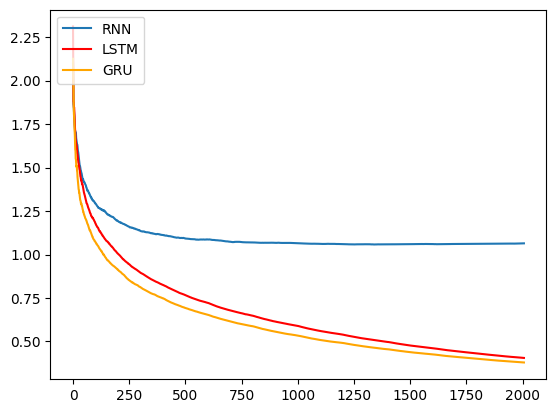

<Figure size 640x480 with 0 Axes>

<BarContainer object of 3 artists>

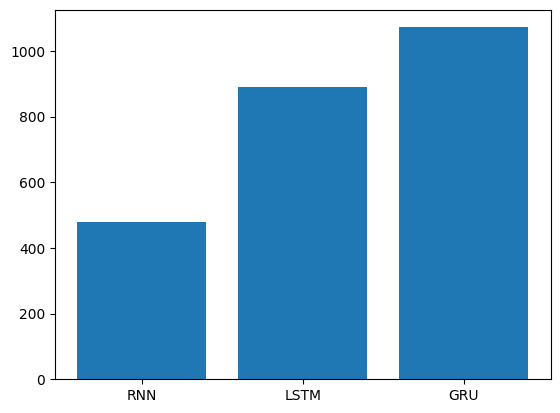

<Figure size 640x480 with 0 Axes>

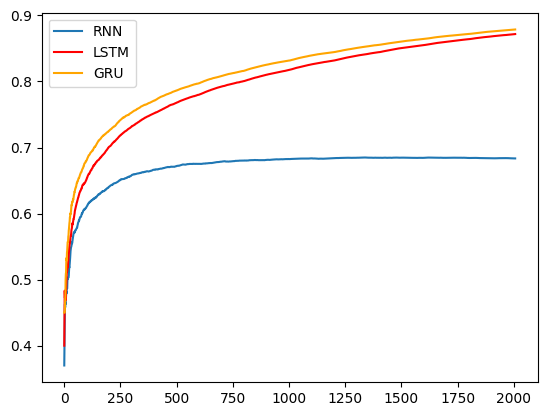

In [ ]:
#@title 绘制对比图
# 绘制损失对比曲线
# 创建画布0
plt.figure(0)
# # 绘制损失对比曲线
plt.plot(total_loss_list, label="RNN")
plt.plot(total_lloss_list, color="red", label="LSTM")
plt.plot(total_gloss_list, color="orange", label="GRU")
plt.legend(loc='upper left')
plt.savefig('RNN_LSTM_GRU_loss2.png')
plt.show()

# 绘制柱状图
# 创建画布1
plt.figure(1)
x_data = ["RNN", "LSTM", "GRU"]
y_data = [total_time, total_ltime, total_gtime]
# 绘制训练耗时对比柱状图
plt.bar(range(len(x_data)), y_data, tick_label=x_data)
plt.savefig('RNN_LSTM_GRU_period2.png')
plt.show()

# 绘制准确率对比曲线
plt.figure(2)
plt.plot(total_acc_list, label="RNN")
plt.plot(total_lacc_list, color="red", label="LSTM")
plt.plot(total_gacc_list, color="orange", label="GRU")
plt.legend(loc='upper left')
plt.savefig('RNN_LSTM_GRU_acc2.png')
plt.show()

In [21]:
#@title 预测结果
# 将人名转化为onehot张量
# eg 'bai' --> [3,57]
def NameToTensor(x):
  tensor_x = torch.zeros(len(x),n_letters)
  for i,letter in enumerate(x):
    tensor_x[i][all_letters.find(letter)] = 1
  return tensor_x

In [15]:
#@title RRN预测
def predict_rnn(x):
  # n_letters = n_letters # Removed to use global n_letters
  # n_hidden = 200 # Removed to use global n_hidden
  # n_countries = categorynum # Removed to use global n_countries

  x_tensor = NameToTensor(x)

  my_rnn = myRNN(input_size=n_letters, hidden_size=200, output_size=categorynum)
  my_rnn.load_state_dict(torch.load('my_rnn_model.bin'))
  my_rnn.eval()

  with torch.no_grad():
    output,hidden = my_rnn(x_tensor,my_rnn.inithidden())
    # Get the index of the highest probability
    topi = torch.argmax(output, dim=1)
    country_idx = topi[0].item()
    country = categorys[country_idx]
    print("rnn-->",x)
    print(f"Predicted category: {country}")

In [16]:
#@title LSTM预测
def predict_lstm(x):
  # n_letters = n_letters # Removed to use global n_letters
  # n_hidden = 200 # Removed to use global n_hidden
  # n_countries = categorynum # Removed to use global n_countries

  x_tensor = NameToTensor(x)

  my_lstm = myLSTM(input_size=n_letters, hidden_size=200, output_size=categorynum)
  my_lstm.load_state_dict(torch.load('my_lstm_model.bin'))
  my_lstm.eval()

  with torch.no_grad():
    hidden,c = my_lstm.inithidden()
    output,hidden,c = my_lstm(x_tensor,hidden,c)
    # Get the index of the highest probability
    topi = torch.argmax(output, dim=1)
    country_idx = topi[0].item()
    country = categorys[country_idx]
    print("lstm-->",x) # Changed from rnn--> to lstm--> for clarity
    print(f"Predicted category: {country}")

In [17]:
#@title GRU预测
def predict_gru(x):
  # n_letters = n_letters # Removed to use global n_letters
  # n_hidden = 200 # Removed to use global n_hidden
  # n_countries = categorynum # Removed to use global n_countries

  x_tensor = NameToTensor(x)

  my_gru = myGRU(input_size=n_letters, hidden_size=200, output_size=categorynum)
  my_gru.load_state_dict(torch.load('my_GRU_model.bin'))
  my_gru.eval()

  with torch.no_grad():
    output,hidden = my_gru(x_tensor,my_gru.inithidden())
    # Get the index of the highest probability
    topi = torch.argmax(output, dim=1)
    country_idx = topi[0].item()
    country = categorys[country_idx]
    print("gru-->",x) # Changed from rnn--> to gru--> for clarity
    print(f"Predicted category: {country}")

In [19]:
#@title 预测调用
def dm_test_predic_rnn_lstm_gru():
        # 把三个函数的入口地址 组成列表，统一输入数据进行测试
    for func in [predict_rnn, predict_lstm, predict_gru]:
        func('Teng')

In [26]:
dm_test_predic_rnn_lstm_gru()

FileNotFoundError: [Errno 2] No such file or directory: 'my_rnn_model.bin'

In [39]:
import torch

if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Number of CUDA devices: {device_count}")
    for i in range(device_count):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
        properties = torch.cuda.get_device_properties(i)
        print(f"  CUDA Capability: {properties.major}.{properties.minor}")
        print(f"  Total memory: {properties.total_memory / (1024**3):.2f} GB")
        print(f"  Multiprocessors: {properties.multi_processor_count}")
        print(f"  Max threads per multiprocessor: {properties.max_threads_per_multi_processor}")
else:
    print("CUDA is not available.")

Number of CUDA devices: 1
Device 0: Tesla T4
  CUDA Capability: 7.5
  Total memory: 14.74 GB
  Multiprocessors: 40
  Max threads per multiprocessor: 1024
